# MNIST digit classifier (KNN classifier)

In [1]:
import numpy as np
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
import mnist

from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import GridSearchCV
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import precision_score, recall_score, f1_score

np.random.seed(12345)

#### Preparing the data

In [2]:
mnist_train_images = mnist.train_images().astype(np.float32) / 255.0
mnist_train_labels = mnist.train_labels()

mnist_val_images = mnist.test_images().astype(np.float32) / 255.0
mnist_val_labels = mnist.test_labels()

In [3]:
TRAIN_SIZE = 10000  # out of 60000
VALID_SIZE = 5000   # out of 10000
DIGIT_DIM  = 28

In [4]:
X_train = np.reshape(mnist_train_images[:TRAIN_SIZE],
                     newshape=(TRAIN_SIZE, DIGIT_DIM * DIGIT_DIM))
y_train = mnist_train_labels[:TRAIN_SIZE]

X_valid = np.reshape(mnist_val_images[:VALID_SIZE],
                     newshape=(VALID_SIZE, DIGIT_DIM * DIGIT_DIM))
y_valid = mnist_val_labels[:VALID_SIZE]

#### Visualization of digits

In [5]:
def plot_digit(data):
    image = data.reshape(28, 28)
    plt.imshow(image, cmap = mpl.cm.binary, interpolation="nearest")
    plt.axis("off")

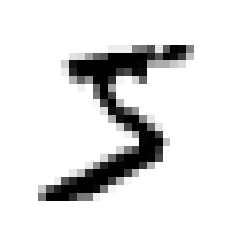

In [6]:
plot_digit(X_train[0])

#### Data analysis

In [7]:
train_df = pd.DataFrame(X_train, dtype=np.float32)
labels_df = pd.DataFrame(y_train, dtype=np.uint32)

digits_OH = OneHotEncoder(
    categories=[np.array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9], dtype=np.uint32)]
).fit_transform(labels_df).todense()
digits_OH = pd.DataFrame(digits_OH)

In [8]:
digit_corrs = []

for digit in range(10):
    corrs = np.zeros(DIGIT_DIM * DIGIT_DIM)

    for i in range(DIGIT_DIM * DIGIT_DIM):
        corrs[i] = train_df[i].corr(digits_OH[digit])
    
    digit_corrs += [corrs.reshape(28, 28)]

Below, one can see correlations between each pixel and actual digit in form of heatmaps.

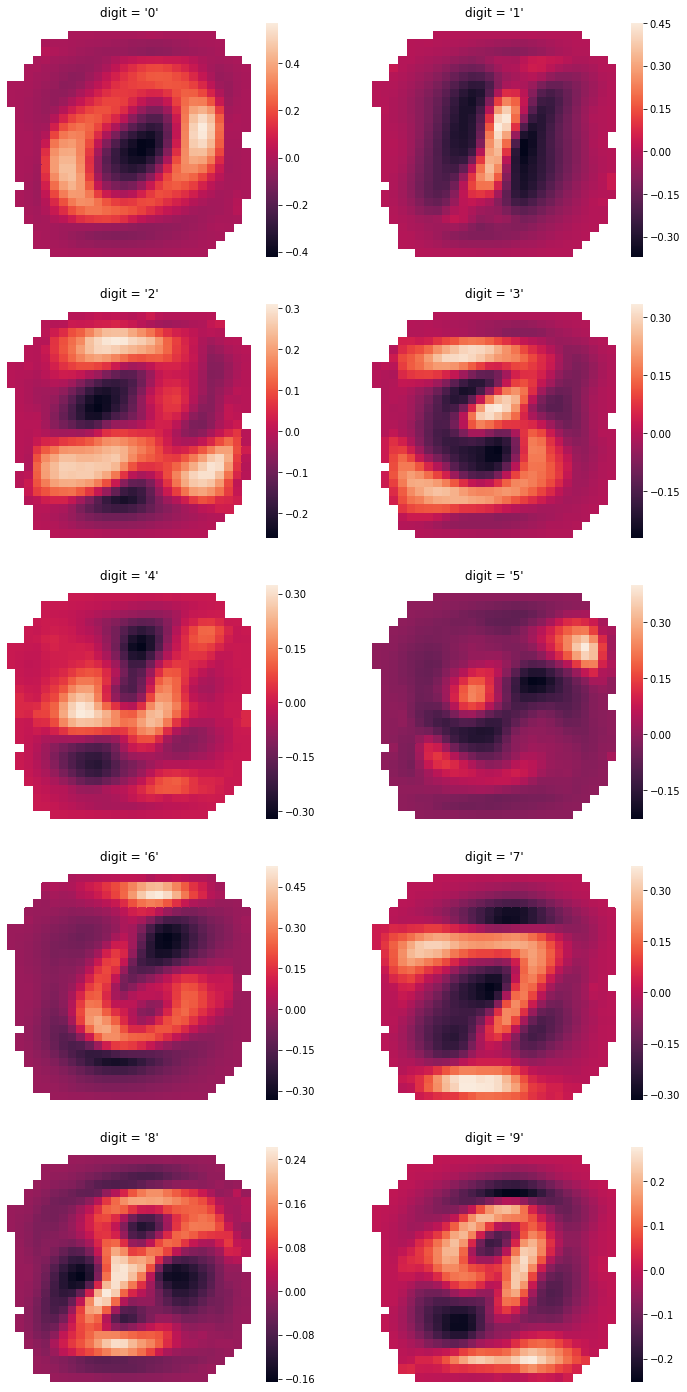

In [9]:
plt.figure(figsize=(12, 25))

for digit in range(10):
    plt.subplot(5, 2, digit+1)
    plt.axis('off')
    plt.title("digit = '{}'".format(digit))
    sns.heatmap(data=digit_corrs[digit])

plt.show()

#### Choosing hyperparameters

Cross calidation in case of a KNN classifier and such a large dataset might be a bti time consuming. Therefore, first of all there will be chosen few set of parameters giving satisfactory results on a small fraction of a dataset. Then, those will be tested on a bigger subsets of data.

In [10]:
param_grid = [{
    'weights': ['uniform', 'distance'],
    'n_neighbors': [3, 4, 5, 6, 7, 8]
}]

In [11]:
knn_classif = KNeighborsClassifier()

grid_search = GridSearchCV(
    estimator = knn_classif,
    param_grid = param_grid,
    cv = 3,
    scoring = 'accuracy',
    verbose = 1,
    iid = True
)

In [12]:
grid_search.fit(X_train[:2000], y_train[:2000])

Fitting 3 folds for each of 12 candidates, totalling 36 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  36 out of  36 | elapsed:   41.9s finished


GridSearchCV(cv=3, error_score='raise-deprecating',
             estimator=KNeighborsClassifier(algorithm='auto', leaf_size=30,
                                            metric='minkowski',
                                            metric_params=None, n_jobs=None,
                                            n_neighbors=5, p=2,
                                            weights='uniform'),
             iid=True, n_jobs=None,
             param_grid=[{'n_neighbors': [3, 4, 5, 6, 7, 8],
                          'weights': ['uniform', 'distance']}],
             pre_dispatch='2*n_jobs', refit=True, return_train_score=False,
             scoring='accuracy', verbose=1)

In [13]:
cv_results = grid_search.cv_results_
results_dict = {'uniform': {}, 'distance': {}}
results_list = []

for mean_score, params in zip(cv_results['mean_test_score'], cv_results['params']):
    results_dict[params['weights']][params['n_neighbors']] = mean_score
    results_list += [(params['weights'], params['n_neighbors'], mean_score)]
    
results_list.sort(key=(lambda x: x[2]))

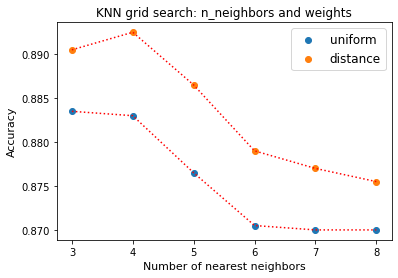

In [14]:
keys = list(results_dict['uniform'].keys())
fig, ax = plt.subplots()

plt.title("KNN grid search: n_neighbors and weights")
plt.xlabel("Number of nearest neighbors", fontsize=11)
plt.ylabel("Accuracy", fontsize=11)

uniform_vals = list(results_dict['uniform'].values())
plt.scatter(np.arange(len(keys)), uniform_vals, label='uniform')
plt.plot(uniform_vals, 'r:')

distance_vals = list(results_dict['distance'].values())
plt.scatter(np.arange(len(keys)), distance_vals, label='distance')
plt.plot(distance_vals, 'r:')

plt.legend(loc="upper right", fontsize=12)
ax.set_xticks(np.arange(len(keys)))
ax.set_xticklabels([str(i) for i in keys])

plt.show()

With those results in mind, we choose 4 best performing parameter sets to apply consecutive testing to them.

In [15]:
best_params = [
    {'weights': [weight], 'n_neighbors': [n_neighbors]}
    for weight, n_neighbors, _ in results_list[-4:]
]

In [16]:
best_params

[{'weights': ['uniform'], 'n_neighbors': [3]},
 {'weights': ['distance'], 'n_neighbors': [5]},
 {'weights': ['distance'], 'n_neighbors': [3]},
 {'weights': ['distance'], 'n_neighbors': [4]}]

In [17]:
knn_classif = KNeighborsClassifier()

grid_search = GridSearchCV(
    estimator = knn_classif,
    param_grid = best_params,
    cv = 3,
    scoring = 'accuracy',
    verbose = 2,
    n_jobs = 4,
    iid = True
)

In [18]:
grid_search.fit(X_train[:5000], y_train[:5000])

Fitting 3 folds for each of 4 candidates, totalling 12 fits


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  12 out of  12 | elapsed:   35.6s remaining:    0.0s
[Parallel(n_jobs=4)]: Done  12 out of  12 | elapsed:   35.6s finished


GridSearchCV(cv=3, error_score='raise-deprecating',
             estimator=KNeighborsClassifier(algorithm='auto', leaf_size=30,
                                            metric='minkowski',
                                            metric_params=None, n_jobs=None,
                                            n_neighbors=5, p=2,
                                            weights='uniform'),
             iid=True, n_jobs=4,
             param_grid=[{'n_neighbors': [3], 'weights': ['uniform']},
                         {'n_neighbors': [5], 'weights': ['distance']},
                         {'n_neighbors': [3], 'weights': ['distance']},
                         {'n_neighbors': [4], 'weights': ['distance']}],
             pre_dispatch='2*n_jobs', refit=True, return_train_score=False,
             scoring='accuracy', verbose=2)

In [19]:
cv_results = grid_search.cv_results_
results_list = []

for mean_score, params in zip(cv_results['mean_test_score'], cv_results['params']):
    print("Weights: '{}',\tNumber of neighbors: '{}',\tScore: {}".format(
        params['weights'], params['n_neighbors'], mean_score
    ))
    results_list += [(params['weights'], params['n_neighbors'], mean_score)]
    
results_list.sort(key=(lambda x: x[2]))

Weights: 'uniform',	Number of neighbors: '3',	Score: 0.9226
Weights: 'distance',	Number of neighbors: '5',	Score: 0.9266
Weights: 'distance',	Number of neighbors: '3',	Score: 0.928
Weights: 'distance',	Number of neighbors: '4',	Score: 0.9294


In [20]:
best_params = grid_search.best_params_
best_params

{'n_neighbors': 4, 'weights': 'distance'}

#### Training and validation

In [21]:
TRAIN_SIZE = 20000  # out of 60000
VALID_SIZE = 5000   # out of 10000

In [22]:
X_train = np.reshape(mnist_train_images[:TRAIN_SIZE],
                     newshape=(TRAIN_SIZE, DIGIT_DIM * DIGIT_DIM))
y_train = mnist_train_labels[:TRAIN_SIZE]

X_valid = np.reshape(mnist_val_images[:VALID_SIZE],
                     newshape=(VALID_SIZE, DIGIT_DIM * DIGIT_DIM))
y_valid = mnist_val_labels[:VALID_SIZE]

In [23]:
knn_classif = KNeighborsClassifier(**best_params, n_jobs=4)
knn_classif

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
                     metric_params=None, n_jobs=4, n_neighbors=4, p=2,
                     weights='distance')

In [24]:
knn_classif.fit(X_train, y_train)

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
                     metric_params=None, n_jobs=4, n_neighbors=4, p=2,
                     weights='distance')

In [25]:
predictions = knn_classif.predict(X_valid)

In [26]:
accuracy = accuracy_score(predictions, y_valid[:VALID_SIZE])
print("Accuracy: {:.2f}%".format(100*accuracy))

Accuracy: 94.02%


#### Analysis of results

We will start off with the confusion matrix.

In [27]:
conf_matrix = confusion_matrix(y_valid[:VALID_SIZE], predictions)
conf_matrix_df = pd.DataFrame(
    data = conf_matrix,
    index = ["Actual '{}'".format(i) for i in range(10)],
    columns = np.arange(10)
)
conf_matrix_df

,0,1,2,3,4,5,6,7,8,9
Actual '0',458,0,1,0,0,0,0,0,1,0
Actual '1',0,567,1,3,0,0,0,0,0,0
Actual '2',6,10,486,5,0,0,3,17,3,0
Actual '3',1,2,2,477,1,4,1,8,2,2
Actual '4',0,3,0,0,462,0,4,1,1,29
Actual '5',1,2,0,9,2,429,6,1,2,4
Actual '6',7,2,0,0,2,2,449,0,0,0
Actual '7',0,25,1,1,3,0,0,472,0,10
Actual '8',5,4,4,18,4,18,2,8,419,7
Actual '9',2,7,2,6,9,1,1,7,3,482


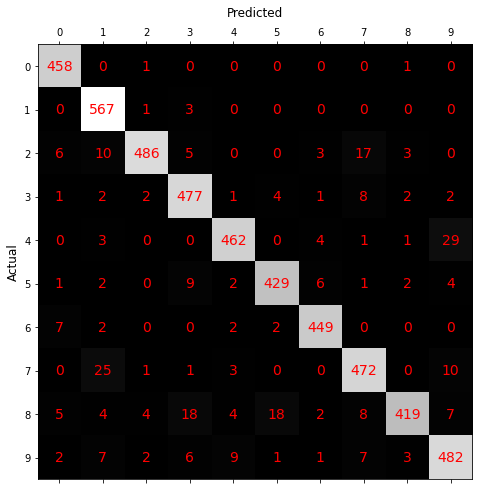

In [28]:
fig, ax = plt.subplots(figsize=(8, 8))
ax.matshow(conf_matrix, cmap=plt.cm.gray)

plt.title("Predicted", fontsize=12)
plt.ylabel("Actual", fontsize=12)
plt.xticks(np.arange(10))
plt.yticks(np.arange(10))

for i in range(10):
    for j in range(10):
        ax.text(j, i, '{}'.format(conf_matrix[i, j]),
                color='red',fontsize=14, ha='center', va='center')

plt.show()

Since the values on the diagonal drastically dominate over the remaining ones, it would be wise to pretend that these are absent and plot the above confusion matrix once again.

Moreover, one should also keep in mind that the digits might not have equal representation among the validation set, which is the case here. This important, because overrepresented digits will naturally have more occurances in their rows and consequently higher values per each cell. Hence, we should scale them to 0-100% range.

In [29]:
digit_occurances = conf_matrix.sum(axis=1, keepdims=True)
normed_conf_matrix = 100 * conf_matrix / digit_occurances
np.fill_diagonal(normed_conf_matrix, np.nan)

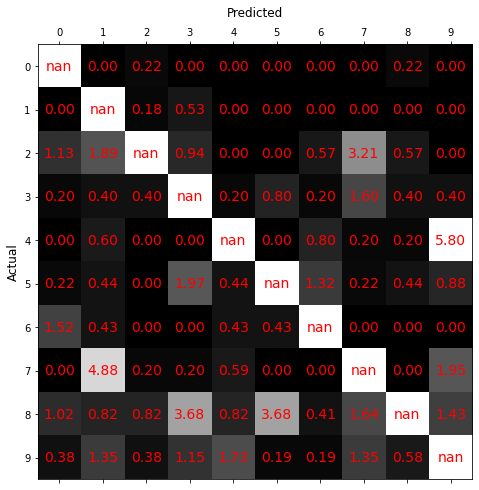

In [30]:
fig, ax = plt.subplots(figsize=(8, 8))
ax.matshow(normed_conf_matrix, cmap=plt.cm.gray)

plt.title("Predicted", fontsize=12)
plt.ylabel("Actual", fontsize=12)
plt.xticks(np.arange(10))
plt.yticks(np.arange(10))

for i in range(10):
    for j in range(10):
        ax.text(j, i, '{:.2f}'.format(normed_conf_matrix[i, j]),
                color='red',fontsize=14, ha='center', va='center')

plt.show()

Precision, recall and f1 scores

In [31]:
precisions = np.array([
    precision_score(y_valid[:VALID_SIZE] == digit, predictions == digit)
    for digit in range(10)
]).reshape(-1, 1)

recalls = np.array([
    recall_score(y_valid[:VALID_SIZE] == digit, predictions == digit)
    for digit in range(10)
]).reshape(-1, 1)

f1_scores = np.array([
    f1_score(y_valid[:VALID_SIZE] == digit, predictions == digit)
    for digit in range(10)
]).reshape(-1, 1)

In [32]:
scores = pd.DataFrame(
    data = np.concatenate((precisions, recalls, f1_scores), axis=1),
    index = ["'{}'".format(i) for i in range(10)],
    columns = ["Precision", "Recall", "F1-score"]
)
scores

,Precision,Recall,F1-score
'0',0.954167,0.995652,0.974468
'1',0.911576,0.992995,0.950545
'2',0.977867,0.916981,0.946446
'3',0.919075,0.954000,0.936212
'4',0.956522,0.924000,0.939980
'5',0.944934,0.940789,0.942857
'6',0.963519,0.971861,0.967672
'7',0.918288,0.921875,0.920078
'8',0.972158,0.856851,0.910870
'9',0.902622,0.926923,0.914611


In [33]:
print("Average scores:")
scores.mean()

Average scores:


Precision    0.942073
Recall       0.940193
F1-score     0.940374
dtype: float64